In [1]:
import torchtext.vocab as vocab
import torch
import pandas as pd
from fastai.vision.all import *

In [2]:
import numpy as np

def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

glove_model = load_glove_model('../input/glove6b/glove.6B.50d.txt')

Loading Glove Model
400000 words loaded!


In [3]:
# 首先得到所有单词的词向量表示
metadata_glove = torch.zeros(12,50).cuda()
metadata_glove[0] = torch.tensor(glove_model['focus'])
metadata_glove[1] = torch.tensor(glove_model['eyes'])
metadata_glove[2] = torch.tensor(glove_model['face'])
metadata_glove[3] = torch.tensor(glove_model['near'])
metadata_glove[4] = torch.tensor(glove_model['action'])
metadata_glove[5] = torch.tensor(glove_model['accessory'])
metadata_glove[6] = torch.tensor(glove_model['group'])
metadata_glove[7] = torch.tensor(glove_model['collage'])
metadata_glove[8] = torch.tensor(glove_model['human'])
metadata_glove[9] = torch.tensor(glove_model['occlusion'])
metadata_glove[10] = torch.tensor(glove_model['info'])
metadata_glove[11] = torch.tensor(glove_model['blur'])

<AxesSubplot:>

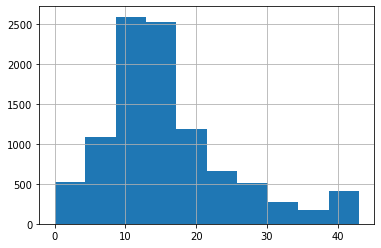

In [4]:
BATCH_SIZE = 40
seed=999
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

train_df = pd.read_csv('../input/petfinder-pawpularity-score/train.csv')
dataset_path = Path('../input/petfinder-pawpularity-score/')
train_df['path'] = train_df['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df['norm_score'] = train_df['Pawpularity']/100
train_df['norm_score']
#Sturges' rule
num_bins = int(np.floor(1+(3.3)*(np.log2(len(train_df)))))
# num_bins
train_df['bins'] = pd.cut(train_df['norm_score'], bins=num_bins, labels=False)
train_df['bins'].hist()



<AxesSubplot:>

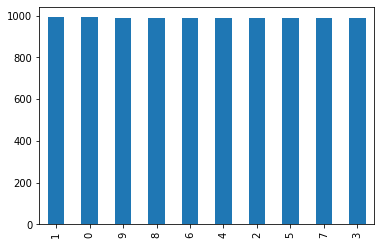

In [5]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

train_df['fold'] = -1


N_FOLDS = 10
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['bins'])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

train_df.fold.value_counts().plot.bar()

In [6]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [7]:
from fastai.tabular.all import *
# 下面这个就是图片的dataloader，做一个tabular的模型
def get_data_meta(fold):
#     train_df_no_val = train_df.query(f'fold != {fold}')
#     train_df_val = train_df.query(f'fold == {fold}')
    
#     train_df_bal = pd.concat([train_df_no_val,train_df_val.sample(frac=1).reset_index(drop=True)])
    train_df_f = train_df.copy()
    # add is_valid for validation fold
    train_df_f['is_valid'] = (train_df_f['fold'] == fold)

    dls = TabularDataLoaders.from_df(train_df_f, 
                                      valid_col='is_valid',
                                      path = '../input/petfinder-pawpularity-score',
                                      y_names="norm_score", 
                                      valid_pct=0.2,
                                      seed=seed, #seed
                                      bs=BATCH_SIZE, 
                                      num_workers=8, 
                                      y_block=RegressionBlock,
                                      cont_names = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',\
                                                    'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']
                                    )
    
    
#     dls = ImageDataLoaders.from_df(train_df_f, #pass in train DataFrame
# #                                valid_pct=0.2, #80-20 train-validation random split
#                                valid_col='is_valid', #
#                                seed=999, #seed
#                                fn_col='path', #filename/path is in the second column of the DataFrame
#                                label_col='norm_score', #label is in the first column of the DataFrame
#                                y_block=RegressionBlock, #The type of target
#                                bs=BATCH_SIZE, #pass in batch size
#                                num_workers=8,
#                                item_tfms=Resize(Image_size, resamples=(Image.BICUBIC, Image.NEAREST)), #pass in item_tfms
#                                batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()]))    #pass in batch_tfms
    
    return dls

In [8]:
dls = get_data_meta(1)

In [9]:
# # metadata 放后面
# class meta_model(Module):
#     def __init__(self, pretrained=True):
#         # self.model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=1)
#         # self.model.head = nn.Linear(self.model.head.in_features, 128) # 输入特征
#         super().__init__()
#         self.dropout = nn.Dropout(0.1) # dropout率
#         self.dense1 = nn.Linear(134, 128) # 全连接层 128+6,6是超参数经过了MLP的映射
#         self.dense2 = nn.Linear(128, 1) # 全连接层，最后弄成softmax
#         self.dense1_meta = nn.Linear(12, 10) # 全连接层
#         self.dense2_meta = nn.Linear(10, 1) # 全连接层
#         # 由于是relu，加上kaiminghe的初始化
#         torch.nn.init.normal_(self.dense1_meta.weight, mean=0, std=np.sqrt(2/12))
#         torch.nn.init.normal_(self.dense2_meta.weight, mean=0, std=np.sqrt(2/10))
#         torch.nn.init.normal_(self.dense1.weight, mean=0, std=np.sqrt(2/134))
#         torch.nn.init.normal_(self.dense2.weight, mean=0, std=np.sqrt(2/128))
#         torch.nn.init.constant_(self.dense1_meta.bias, 0.)
#         torch.nn.init.constant_(self.dense2_meta.bias, 0.)
#         torch.nn.init.constant_(self.dense1.bias, 0.)
#         torch.nn.init.constant_(self.dense2.bias, 0.)
#         self.step_scheduler_after = "epoch"
#     def forward(self, features):
#         # embedding = metadata_glove*features # 获得embedding结果，如果是0，就是zeros
# #         x = self.dense1(features)
# #         meta_MLP = self.dense1_meta(features)
# #         meta_MLP = nn.functional.relu(meta_MLP)
# #         meta_MLP = self.dense2_meta(meta_MLP)
# #         meta_MLP = nn.functional.relu(meta_MLP)
# #         x = torch.cat([x, meta_MLP], dim=1) # 将超数据与文字数据通过全连接层的隐藏层进行了链接
#         x = self.dense1_meta(features) # 全连接进行输出
#         x = nn.functional.relu(x)
#         x = self.dense2_meta(x)
#         return x

In [10]:
import torch.nn as nn
import torch
# class PawpularModel_meta(nn.Module):
#     def __init__(self, model_name='swin_large_patch4_window7_224', num_classes=[12,1],
#                  n_meta_dim=[256, 128], pretrained=True):
#         super().__init__()
#         out_dim=num_classes[1] # 输出1
#         n_meta_features=num_classes[0] # meta维度 17
#         self.n_meta_features = n_meta_features
#         # self.enet = create_model(model_name, pretrained=True, in_chans=3) # 这里没有标准化，输出是维度是1536
#         self.dropouts = nn.ModuleList([
#             nn.Dropout(0.5) for _ in range(5)
#         ])
#         # in_ch = self.enet.head.in_features # 768*2=1536维度
#         if n_meta_features > 0:
#             self.meta = nn.Sequential(
#                 nn.Linear(n_meta_features, n_meta_dim[0]), # 17 到 256维度
#                 nn.BatchNorm1d(n_meta_dim[0]), # norm操作 维度256
#                 nn.SiLU(), # 激活函数
#                 nn.Dropout(p=0.3), # drop0.3
#                 nn.Linear(n_meta_dim[0], n_meta_dim[1]), # 256 到 128 维度
#                 nn.BatchNorm1d(n_meta_dim[1]), # norm操作 维度128
#                 nn.SiLU(), # 激活函数
#             )
            
#             #in_ch += n_meta_dim[1] # 128+768*2维度，将meta拼接到前面
#             # print('in_ch is ' + str(in_ch))
#         self.myfc = nn.Linear(n_meta_dim[1], out_dim) # 1664到1
#         # self.enet.head = nn.Identity()

# #     def extract(self, x):
# #         x = self.enet(x) # 输出768*2
# #         #print(x.shape)
# #         return x

#     def forward(self, ff, features):
#         #print(features)
#         #print(ff)
#         x_meta = self.meta(features) # meta输入，得到128维度
#         out = self.myfc(x_meta)
        
# #         x = self.extract(image).squeeze(-1).squeeze(-1) # 用swin输出得到1536
# #         #print(x.shape) #1536=768*2
# #         if self.n_meta_features > 0:
# #             x_meta = self.meta(features) # meta输入，得到128维度
# #             x = torch.cat((x, x_meta), dim=1) # 将meta和swin拼接起来 128+1536 = 1664
# #         for i, dropout in enumerate(self.dropouts):
# #             if i == 0:
# #                 out = self.myfc(dropout(x))
# #             else:
# #                 out += self.myfc(dropout(x)) # 相当于将1664同时经过了5个全连接，然后求和，这里是串行的程序，可以修改为并行，将输出设定为5维，然后再从5维到1维
# #         out /= len(self.dropouts) # 求一个平均，没什么意义，我将1664到1维的权重学习为原来的五分之一就可以达到一样的效果
#         return out
class PawpularModel_meta(nn.Module):
    def __init__(self, model_name='swin_large_patch4_window7_224', num_classes=[12,1], reduction_dim = 5,
                 n_meta_dim=[256, 128], pretrained=True):
        super().__init__()
        out_dim=num_classes[1] # 输出1
        n_meta_features=num_classes[0] # meta维度 17
        self.reduce_d = nn.Linear(50, reduction_dim) # embedding降维到5 
        self.meta_order1 = nn.Linear(432+60, 100)
        self.meta_order2 = nn.Linear(100, 10)
        self.meta_order3 = nn.Linear(10, 1)
        self.dropout = nn.Dropout(0.5)




        # self.n_meta_features = n_meta_features
        # # self.enet = create_model(model_name, pretrained=True, in_chans=3) # 这里没有标准化，输出是维度是1536
        # self.dropouts = nn.ModuleList([
        #     nn.Dropout(0.5) for _ in range(5)
        # ])
        # # in_ch = self.enet.head.in_features # 768*2=1536维度
        # if n_meta_features > 0:
        #     self.meta = nn.Sequential(
        #         nn.Linear(n_meta_features, n_meta_dim[0]), # 17 到 256维度
        #         nn.BatchNorm1d(n_meta_dim[0]), # norm操作 维度256
        #         nn.SiLU(), # 激活函数
        #         nn.Dropout(p=0.3), # drop0.3
        #         nn.Linear(n_meta_dim[0], n_meta_dim[1]), # 256 到 128 维度
        #         nn.BatchNorm1d(n_meta_dim[1]), # norm操作 维度128
        #         nn.SiLU(), # 激活函数
        #     )
            
        #     #in_ch += n_meta_dim[1] # 128+768*2维度，将meta拼接到前面
        #     # print('in_ch is ' + str(in_ch))
        # self.myfc = nn.Linear(n_meta_dim[1], out_dim) # 1664到1
        # self.enet.head = nn.Identity()

#     def extract(self, x):
#         x = self.enet(x) # 输出768*2
#         #print(x.shape)
#         return x

    def forward(self, ff, features):
        #print(features)
        #print(ff)
        embed = torch.zeros(BATCH_SIZE, *metadata_glove.shape).cuda()
        for idx, eve_feature in enumerate(features):
            embed[idx] = (eve_feature*metadata_glove.T).T
        embed_reduce = self.reduce_d(embed) # 获得了降维的tensor
        embed_norm = torch.norm(embed_reduce, dim=2)
        embed_norm = embed_norm.unsqueeze(2)
        embed_reduce = embed_reduce/embed_norm # 获得归一化的降维的向量
        #embed_reduce = embed
        dot_result = torch.bmm(embed_reduce, embed_reduce.permute(0,2,1)).reshape(BATCH_SIZE, -1)
        dot_tanh = torch.tanh(dot_result) 
        dot_relu = torch.relu(dot_result) 
        dot_sig = torch.sigmoid(dot_result) 
        
        hig_order = torch.cat([dot_tanh, dot_relu, dot_sig], 1)
        all_order = torch.cat([embed_reduce.reshape(BATCH_SIZE, -1), hig_order], 1)
        
        out1 = self.meta_order1(self.dropout(all_order))
        out2 = self.meta_order2(self.dropout(out1))
        out3 = self.meta_order3(self.dropout(out2))
#         x = self.extract(image).squeeze(-1).squeeze(-1) # 用swin输出得到1536
#         #print(x.shape) #1536=768*2
#         if self.n_meta_features > 0:
#             x_meta = self.meta(features) # meta输入，得到128维度
#             x = torch.cat((x, x_meta), dim=1) # 将meta和swin拼接起来 128+1536 = 1664
#         for i, dropout in enumerate(self.dropouts):
#             if i == 0:
#                 out = self.myfc(dropout(x))
#             else:
#                 out += self.myfc(dropout(x)) # 相当于将1664同时经过了5个全连接，然后求和，这里是串行的程序，可以修改为并行，将输出设定为5维，然后再从5维到1维
#         out /= len(self.dropouts) # 求一个平均，没什么意义，我将1664到1维的权重学习为原来的五分之一就可以达到一样的效果
        return out3

In [11]:
def get_learner_meta(fold_num):
    data = get_data_meta(fold_num)
    model = PawpularModel_meta()
#     if meta:
#         print("data.c:", data.c)
#         model = PawpularModel(Model_name, num_classes=data.c) # 如果有超参数，就用上面写好的模型
#     else:    
#         model = create_model(Model_name, pretrained=True, num_classes=data.c)
    learn = Learner(data, model, loss_func = petfinder_rmse, metrics=petfinder_rmse) # 默认就是全连接神经网络
    #learn = tabular_learner(data,  loss_func = petfinder_rmse, metrics=petfinder_rmse) # 默认就是全连接神经网络
    # learn = Learner(data, model, loss_func=BCEWithLogitsLossFlat(), metrics=petfinder_rmse).to_fp16()
    
    return learn

In [12]:
# 下面开始弄图片

In [13]:
import sys
from PIL import Image
import imagehash
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
from timm import create_model
from timm.data.mixup import Mixup
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import albumentations
tqdm.pandas()

In [14]:
from fastai.vision.all import *

In [15]:

if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'


In [16]:
def get_data_pic(fold):
#     train_df_no_val = train_df.query(f'fold != {fold}')
#     train_df_val = train_df.query(f'fold == {fold}')
    
#     train_df_bal = pd.concat([train_df_no_val,train_df_val.sample(frac=1).reset_index(drop=True)])
    train_df_f = train_df.copy()
    # add is_valid for validation fold
    train_df_f['is_valid'] = (train_df_f['fold'] == fold)
    
    dls = ImageDataLoaders.from_df(train_df_f, #pass in train DataFrame
#                                valid_pct=0.2, #80-20 train-validation random split
                               valid_col='is_valid', #
                               seed=seed, #seed
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(224), #pass in item_tfms
                               #batch_tfms=setup_aug_tfms([RandomErasing(),  Rotate(),   Flip()]))
                               batch_tfms=setup_aug_tfms([RandomErasing(), Rotate(),  Zoom(), Brightness(), Flip(), Contrast(), Saturation()])) #pass in batch_tfms
    
    return dls


In [17]:
def get_learner_pic(fold_num):
    data = get_data_pic(fold_num)
    
    model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=1)
    # print(model.head.in_features) 768*2=1536
    learn = Learner(data, model, loss_func=BCEWithLogitsLossFlat(), metrics=AccumMetric(func=petfinder_rmse), cbs=[MixUp(0.2)]).to_fp16()
    
    return learn

In [18]:
test_df = pd.read_csv('../input/petfinder-pawpularity-score/test.csv')
test_df['Pawpularity'] = [1]*len(test_df)
test_df['path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
test_df = test_df.drop(columns=['Id'])

Fold 0 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,21.558857,20.466156,20.466156,00:05
1,21.148006,20.694565,20.694565,00:04
2,20.596495,20.345676,20.345676,00:04
3,20.421499,20.399458,20.399458,00:04
4,20.776445,20.339447,20.339447,00:04
5,20.696554,20.410679,20.410679,00:04
6,20.219736,20.383551,20.383551,00:04


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Using a target size (torch.Size([22, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  


No improvement since epoch 4: early stopping


meta process is done!


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.655276,0.647675,18.556986,07:03
1,0.650162,0.640805,17.649927,06:57
2,0.646256,0.641562,17.747580,06:56
3,0.644162,0.639471,17.458120,06:56
4,0.640495,0.639794,17.499357,06:58


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6476750373840332.
Better model found at epoch 1 with valid_loss value: 0.6408049464225769.
Better model found at epoch 3 with valid_loss value: 0.639470636844635.


pic process is done!
meta_weight is 0.0015038067940622568
pic_weight is 0.9998329877853394
Fold 1 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,21.957317,20.476133,20.476133,00:04
1,21.600340,20.466753,20.466753,00:04
2,21.213799,20.567474,20.567474,00:04
3,21.040075,20.461241,20.461241,00:04
4,20.958132,20.460442,20.460442,00:04
5,20.786720,20.635645,20.635645,00:04
6,20.914606,20.492105,20.492105,00:04


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Using a target size (torch.Size([22, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  


No improvement since epoch 4: early stopping


meta process is done!


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.658301,0.650731,19.009981,06:57
1,0.649138,0.640394,17.698795,06:57
2,0.646466,0.638529,17.441704,06:57
3,0.641761,0.639071,17.507605,06:58
4,0.640285,0.638177,17.385286,06:57


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6507306098937988.
Better model found at epoch 1 with valid_loss value: 0.6403937935829163.
Better model found at epoch 2 with valid_loss value: 0.6385288238525391.
Better model found at epoch 4 with valid_loss value: 0.6381770372390747.


pic process is done!
meta_weight is 6.424095317925094e-06
pic_weight is 0.9999992847442627
Fold 2 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,21.793957,20.779896,20.779896,00:04
1,21.336985,20.455999,20.455999,00:04
2,21.063202,20.575567,20.575567,00:04
3,20.935987,20.501518,20.501518,00:04


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Using a target size (torch.Size([22, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  


No improvement since epoch 1: early stopping


meta process is done!


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.655805,0.649785,18.786188,06:56
1,0.649948,0.642971,17.910572,06:57
2,0.646488,0.643857,18.022709,06:57
3,0.641237,0.643524,17.973581,06:57


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6497848033905029.
Better model found at epoch 1 with valid_loss value: 0.6429707407951355.
No improvement since epoch 1: early stopping


pic process is done!
meta_weight is 0.0
pic_weight is 1.0
Fold 3 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,22.285625,20.851542,20.851542,00:04
1,21.025658,20.808496,20.808496,00:04
2,21.328283,20.600771,20.600771,00:04
3,21.024548,20.678465,20.678465,00:04
4,20.594471,20.454578,20.454578,00:04
5,20.824064,20.456841,20.456841,00:04
6,20.807846,20.525667,20.525667,00:04


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Using a target size (torch.Size([22, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  


No improvement since epoch 4: early stopping


meta process is done!


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.656022,0.645248,18.167629,06:58
1,0.648611,0.639932,17.463835,06:58
2,0.647175,0.637214,17.096687,06:58
3,0.642304,0.637133,17.087774,06:58
4,0.642476,0.637022,17.073153,06:57


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6452476382255554.
Better model found at epoch 1 with valid_loss value: 0.639931857585907.
Better model found at epoch 2 with valid_loss value: 0.6372136473655701.
Better model found at epoch 3 with valid_loss value: 0.6371327042579651.
Better model found at epoch 4 with valid_loss value: 0.637021541595459.


pic process is done!
meta_weight is 0.0
pic_weight is 1.0
Fold 4 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,21.877502,20.470070,20.470070,00:04
1,21.941355,20.570795,20.570795,00:04
2,21.408442,20.459293,20.459293,00:05
3,21.090771,20.656147,20.656147,00:04
4,21.025602,20.539827,20.539827,00:04


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Using a target size (torch.Size([22, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  


No improvement since epoch 2: early stopping


meta process is done!


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.657640,0.647441,18.561632,06:57
1,0.650464,0.644252,18.141947,06:57
2,0.644801,0.643270,18.025345,06:57
3,0.640824,0.642878,17.943245,06:58
4,0.643278,0.642722,17.947334,06:58


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6474405527114868.
Better model found at epoch 1 with valid_loss value: 0.6442522406578064.
Better model found at epoch 2 with valid_loss value: 0.6432701349258423.
Better model found at epoch 3 with valid_loss value: 0.6428781747817993.
Better model found at epoch 4 with valid_loss value: 0.642722487449646.


pic process is done!
meta_weight is 0.0
pic_weight is 1.0
Fold 5 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,22.291094,20.625973,20.625973,00:04
1,21.731428,20.465094,20.465094,00:04
2,21.120169,20.462019,20.462019,00:04
3,21.281815,20.515446,20.515446,00:04
4,21.415390,20.483772,20.483772,00:04


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Using a target size (torch.Size([22, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  


No improvement since epoch 2: early stopping


meta process is done!


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.659901,0.647883,18.649601,06:58
1,0.646528,0.644173,18.162203,06:58
2,0.645910,0.640096,17.659096,06:58
3,0.642444,0.638964,17.514706,06:57
4,0.641160,0.638926,17.504436,06:57


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6478831768035889.
Better model found at epoch 1 with valid_loss value: 0.6441727876663208.
Better model found at epoch 2 with valid_loss value: 0.6400955319404602.
Better model found at epoch 3 with valid_loss value: 0.6389643549919128.
Better model found at epoch 4 with valid_loss value: 0.638926088809967.


pic process is done!
meta_weight is 2.9345756047405303e-05
pic_weight is 0.9999967217445374
Fold 6 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,22.021656,20.968819,20.968819,00:04
1,21.591806,20.458891,20.458891,00:04
2,21.165358,20.650253,20.650253,00:04
3,20.804941,20.458672,20.458672,00:04
4,21.087807,20.456642,20.456642,00:05
5,20.747583,20.452259,20.452259,00:04
6,20.763969,20.456516,20.456516,00:04
7,20.814384,20.491892,20.491892,00:04


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Using a target size (torch.Size([22, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  


No improvement since epoch 5: early stopping


meta process is done!


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.657933,0.649938,18.862455,06:58
1,0.648030,0.645980,18.339191,06:57
2,0.644476,0.643450,18.012243,06:57
3,0.641531,0.642425,17.875729,06:57
4,0.639786,0.642316,17.860905,06:57


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6499378085136414.
Better model found at epoch 1 with valid_loss value: 0.6459799408912659.
Better model found at epoch 2 with valid_loss value: 0.6434497237205505.
Better model found at epoch 3 with valid_loss value: 0.6424251198768616.
Better model found at epoch 4 with valid_loss value: 0.6423155069351196.


pic process is done!
meta_weight is 9.439046152692754e-06
pic_weight is 0.9999986290931702
Fold 7 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,21.999960,20.566736,20.566736,00:04
1,21.770725,20.673546,20.673546,00:04
2,21.187290,20.527647,20.527647,00:04
3,20.998308,20.574064,20.574064,00:04
4,20.893978,20.492807,20.492807,00:04
5,20.811539,20.451693,20.451693,00:04
6,20.654907,20.453299,20.453299,00:04
7,20.675947,20.457838,20.457838,00:05


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Using a target size (torch.Size([22, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  


No improvement since epoch 5: early stopping


meta process is done!


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.656299,0.650445,18.866127,06:59
1,0.648148,0.643453,18.009632,06:58
2,0.644803,0.645212,18.198919,06:58
3,0.642346,0.642741,17.924171,06:57
4,0.641597,0.642572,17.904421,06:58


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6504446268081665.
Better model found at epoch 1 with valid_loss value: 0.6434533596038818.
Better model found at epoch 3 with valid_loss value: 0.6427405476570129.
Better model found at epoch 4 with valid_loss value: 0.6425716876983643.


pic process is done!
meta_weight is 0.0002637898433022201
pic_weight is 0.9999608397483826
Fold 8 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,22.314436,20.979017,20.979017,00:04
1,21.068621,20.509436,20.509436,00:04
2,21.320263,20.514420,20.514420,00:04
3,20.598305,20.479450,20.479450,00:04
4,20.658207,20.454145,20.454145,00:04
5,20.779913,20.473375,20.473375,00:04
6,20.212351,20.530262,20.530262,00:04


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Using a target size (torch.Size([22, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  


No improvement since epoch 4: early stopping


meta process is done!


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.657842,0.647466,18.526985,06:57
1,0.647634,0.642273,17.852631,06:57
2,0.645844,0.639706,17.518200,06:57
3,0.643382,0.638188,17.306973,06:57
4,0.640921,0.638213,17.308832,06:57


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6474664211273193.
Better model found at epoch 1 with valid_loss value: 0.6422732472419739.
Better model found at epoch 2 with valid_loss value: 0.6397061944007874.
Better model found at epoch 3 with valid_loss value: 0.6381877064704895.


pic process is done!
meta_weight is 0.0
pic_weight is 1.0
Fold 9 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,21.989258,20.598303,20.598303,00:04
1,21.460163,20.560114,20.560114,00:04
2,21.236961,20.458952,20.458952,00:04
3,20.886137,20.895985,20.895985,00:04
4,20.677118,20.455162,20.455162,00:04
5,20.564545,20.476719,20.476719,00:04
6,20.498201,20.473282,20.473282,00:04


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Using a target size (torch.Size([22, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  


No improvement since epoch 4: early stopping


meta process is done!


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.657349,0.644665,18.219194,06:57
1,0.649842,0.639737,17.579626,06:57
2,0.644491,0.638907,17.471712,06:57
3,0.641367,0.636888,17.207386,06:58
4,0.640067,0.636205,17.114193,06:57


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6446645259857178.
Better model found at epoch 1 with valid_loss value: 0.6397374272346497.
Better model found at epoch 2 with valid_loss value: 0.6389074325561523.
Better model found at epoch 3 with valid_loss value: 0.6368876099586487.
Better model found at epoch 4 with valid_loss value: 0.636204719543457.


pic process is done!
meta_weight is 6.226743425941095e-05
pic_weight is 0.9999945759773254


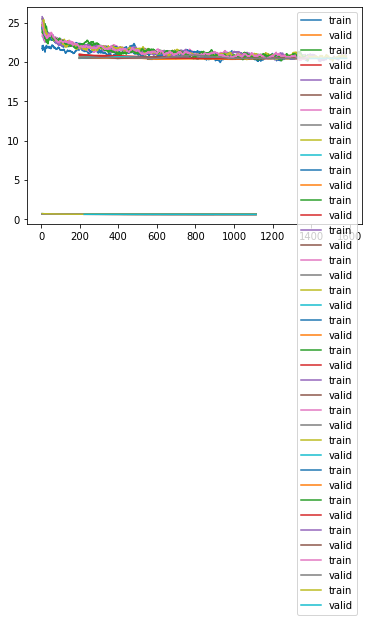

In [19]:
import gc
all_preds = []

for i in range(N_FOLDS):

    print(f'Fold {i} results')
    
    learn_meta = get_learner_meta(fold_num=i) # 先弄一个meta模型

#    learn.fit_one_cycle(5, 2e-5, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=2)]) 
    learn_meta.fit_one_cycle(10, cbs=[EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=2)]) 
    
    val_mse_meta = learn_meta.recorder.values[-1][2]
    # 第二个参数是最大的学习率
    learn_meta.recorder.plot_loss()

    #learn = learn.to_fp32()
    
    #learn.export(f'model_fold_{i}.pkl')
    #learn.save(f'model_fold_{i}.pkl')
    
    dls_meta = TabularDataLoaders.from_df(train_df, 
                                      valid_col='is_valid',
                                      path = '../input/petfinder-pawpularity-score',
                                      y_names="norm_score", 
                                      #valid_pct=0.2,
                                      seed=seed, #seed
                                      bs=BATCH_SIZE, 
                                      num_workers=8, 
                                      y_block=RegressionBlock,
                                      cont_names = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',\
                                                    'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']
                                    )
                                     
    
    test_dl_meta = dls_meta.test_dl(test_df)
    
    preds_meta, _ = learn_meta.get_preds(dl=test_dl_meta)
    
    
    
    del learn_meta

    torch.cuda.empty_cache()

    gc.collect() # meta弄完了
    
    print('meta process is done!')
    
    learn_pic = get_learner_pic(fold_num=i)

    learn_pic.fit_one_cycle(5, 2e-5, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=2)]) 
    
    val_mse_pic = learn_pic.recorder.values[-1][2]
    # *************************************************************************************** was 5
    # 第二个参数是最大的学习率
    learn_pic.recorder.plot_loss()

    #learn = learn.to_fp32()
    
    #learn.export(f'model_fold_{i}.pkl')
    #learn.save(f'model_fold_{i}.pkl')
    
    dls_pic = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
                               #valid_pct=0.2, #80-20 train-validation random split
                               seed=seed, #seed
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(224), #pass in item_tfms
                               #batch_tfms=setup_aug_tfms([RandomErasing(),  Rotate(),   Flip()]))    
                                batch_tfms=setup_aug_tfms([RandomErasing(),  Rotate(),  Brightness(), Flip(), Contrast(), Saturation()])) 
    
    test_dl_pic = dls_pic.test_dl(test_df)
    
    preds_pic, _ = learn_pic.tta(dl=test_dl_pic, n=5, beta=0)
    
    
    
    del learn_pic

    torch.cuda.empty_cache()

    gc.collect()
    print('pic process is done!')
    # 通过pic和meta计算权重
    meta_weight = torch.nn.functional.relu_(torch.tensor(20.5-val_mse_meta))**2
    pic_weight = torch.nn.functional.relu_(torch.tensor(20.5-val_mse_pic))**2
    # 归一化
    meta_weight = meta_weight/(meta_weight+pic_weight)
    pic_weight = pic_weight/(meta_weight+pic_weight)
    print('meta_weight is ' + str(meta_weight.item()))
    print('pic_weight is ' + str(pic_weight.item()))
    all_preds.append(preds_meta*meta_weight+preds_pic*pic_weight)

In [20]:
all_preds

[tensor([[0.4463],
         [0.4431],
         [0.4452],
         [0.4394],
         [0.4389],
         [0.4400],
         [0.4519],
         [0.4482]]),
 tensor([[0.4126],
         [0.4200],
         [0.4184],
         [0.4233],
         [0.4263],
         [0.4187],
         [0.4260],
         [0.4192]]),
 tensor([[0.4500],
         [0.4363],
         [0.4439],
         [0.4385],
         [0.4418],
         [0.4344],
         [0.4448],
         [0.4378]]),
 tensor([[0.4434],
         [0.4413],
         [0.4379],
         [0.4457],
         [0.4441],
         [0.4440],
         [0.4543],
         [0.4496]]),
 tensor([[0.4868],
         [0.4839],
         [0.4890],
         [0.4883],
         [0.4895],
         [0.4872],
         [0.4879],
         [0.4846]]),
 tensor([[0.4681],
         [0.4818],
         [0.4726],
         [0.4812],
         [0.4689],
         [0.4783],
         [0.4775],
         [0.4779]]),
 tensor([[0.4448],
         [0.4417],
         [0.4462],
         [0.4470],


In [21]:
sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
preds = np.mean(np.stack(all_preds), axis=0)
sample_df['Pawpularity'] = preds*100
sample_df.to_csv('submission.csv',index=False)